In [1]:
import os
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
import tensorflowjs as tfjs

In [2]:
# from PIL import Image
# from io import BytesIO
# from uuid import uuid4

# train_df = pd.read_parquet("/Users/joshua/Documents/affectnet_short/data/train-00000-of-00001-7cbcbf03ccc4c14c.parquet")
# val_df = pd.read_parquet("/Users/joshua/Documents/affectnet_short/data/val-00000-of-00001-15bd8d507ff5dd11.parquet")

# MAPPING = {0: "anger", 1: "surprise", 2: "contempt", 3: "happy", 4: "neutral", 5: "fear", 6: "sad", 7: "disgust"}
# for uniq in train_df.label.unique():
#     os.makedirs(f"quality_dataset/train/{MAPPING[uniq]}")
#     os.makedirs(f"quality_dataset/val/{MAPPING[uniq]}")

# def save_img(row, mode): 
#     im = Image.open(BytesIO(row.image["bytes"]))
#     im.save(os.path.join(f"./quality_dataset/{mode}", MAPPING[row.label], str(uuid4()) + ".jpg"))

# _ = train_df.apply(lambda x: save_img(x, "train"), axis = 1)
# _ = val_df.apply(lambda x: save_img(x, "val"), axis = 1)

In [3]:
train_dir = "./quality_dataset/train"
val_dir = "./quality_dataset/val"

# Create training generator.
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, label_mode = "categorical", image_size=(96, 96), batch_size=32)
LABEL_MAP = dict(enumerate(train_ds.class_names))

@tf.function
def data_augmentation(images, labels):
  images = tf.image.random_flip_left_right(images)
  images = tf.image.random_saturation(images, 0.65, 1.45)
  images = tf.image.random_brightness(images, max_delta=0.3)
  return images, labels

train_ds = train_ds.map(data_augmentation)

# Create validation generator.
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, label_mode = "categorical", image_size=(96, 96), batch_size=32)

# Prefetch for loading speed.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10677 files belonging to 3 classes.
Found 2669 files belonging to 3 classes.


2024-02-02 15:08:22.355548: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


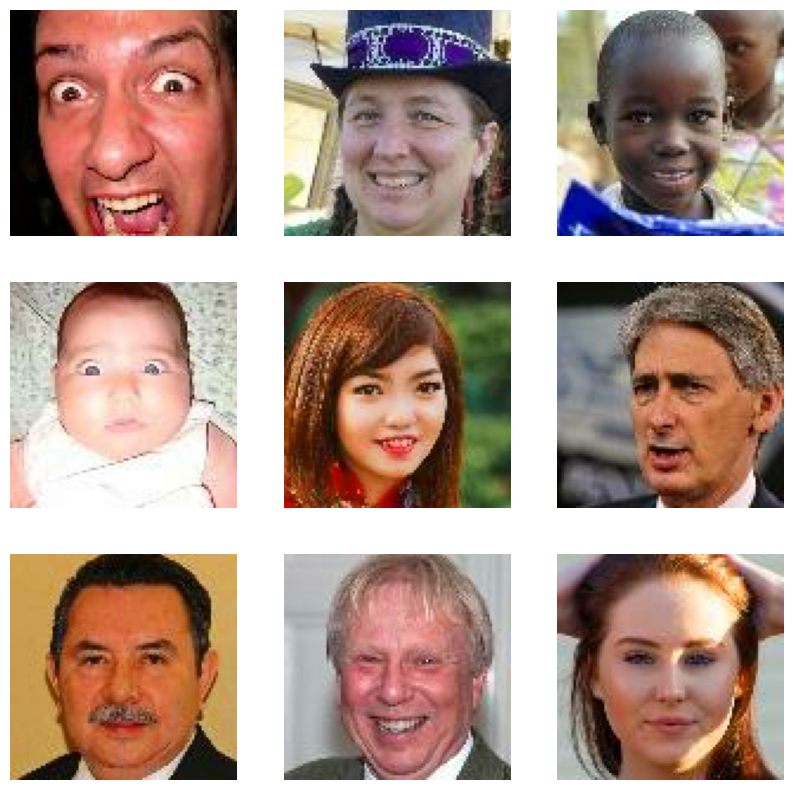

In [4]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [5]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model


# def build_cnn(conv_blocks=3, classifier_blocks = 2, filters=64, kernel_size=3, input_shape=(96,96,3), 
#               pool_size=2, dense_units=64, num_classes=6, dropout_rate=0.2, **kwargs):
        
#     inputs = Input(shape=input_shape)
#     x = tf.keras.layers.Rescaling(1./255)(inputs)
#     x = tf.keras.layers.RandomFlip("horizontal")(x)
#     x = tf.keras.layers.RandomRotation(0.1)(x)

#     # Add convolutional blocks
#     for _ in range(conv_blocks):
 
#         x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding = "same", kernel_regularizer=tf.keras.regularizers.l2())(x)
#         x = MaxPooling2D(pool_size=pool_size)(x)
#         x = BatchNormalization()(x)
#         x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)   
#         x = Dropout(dropout_rate)(x)
        
#     x = Flatten()(x)

#     # Add classifier head.
#     for _ in range(classifier_blocks):
#         x = Dense(units=dense_units)(x)
#         x = tf.keras.layers.LeakyReLU(alpha=0.3)(x)
#         x = Dropout(dropout_rate)(x)

#     outputs = Dense(num_classes, activation='softmax')(x)
    
#     # Define the model
#     model = Model(inputs=inputs, outputs=outputs)
    
#     return model

def build_feature_cnn(input_shape=(96,96,3), num_classes=3):
    
    # Define feature extraction layer.
    feature_extractor = tf.keras.applications.EfficientNetV2S(input_shape = input_shape, include_top = False)
    feature_extractor.trainable = False

    # Build transfer learning model.
    inputs = Input(shape=input_shape)
    x = feature_extractor(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    return model


In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model = build_feature_cnn()
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate = 0.02), loss='categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_ds, validation_data = val_ds, epochs = 40, callbacks = [early_stopping])

Epoch 1/40
334/334 [==============================] - 67s 170ms/step - loss: 1.0215 - accuracy: 0.5307 - val_loss: 0.7885 - val_accuracy: 0.6336
Epoch 2/40
334/334 [==============================] - 39s 117ms/step - loss: 0.7751 - accuracy: 0.6478 - val_loss: 0.7219 - val_accuracy: 0.6669
Epoch 3/40
334/334 [==============================] - 38s 114ms/step - loss: 0.6988 - accuracy: 0.6854 - val_loss: 0.6856 - val_accuracy: 0.6842
Epoch 4/40
334/334 [==============================] - 39s 117ms/step - loss: 0.6459 - accuracy: 0.7129 - val_loss: 0.6640 - val_accuracy: 0.6976
Epoch 5/40
334/334 [==============================] - 38s 113ms/step - loss: 0.6035 - accuracy: 0.7340 - val_loss: 0.6486 - val_accuracy: 0.7063
Epoch 6/40
334/334 [==============================] - 40s 119ms/step - loss: 0.5669 - accuracy: 0.7555 - val_loss: 0.6398 - val_accuracy: 0.7119
Epoch 7/40
334/334 [==============================] - 42s 125ms/step - loss: 0.5338 - accuracy: 0.7728 - val_loss: 0.6366 - val_ac

In [8]:
# model.layers[1].trainable = True
# model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate = 0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
# history = model.fit(train_ds, validation_data = val_ds, epochs = 20, callbacks = [early_stopping])

In [8]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "webcam/public/model")

/opt/homebrew/Caskroom/miniforge/base/envs/emotions/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
%%capture
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

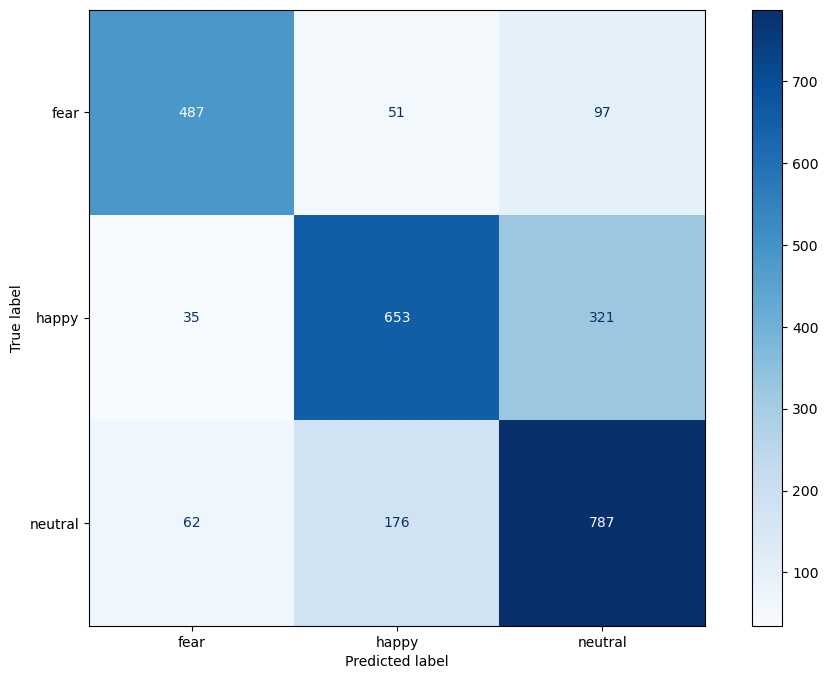

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(LABEL_MAP.values()))
disp.plot(cmap=plt.cm.Blues)
fig =plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

In [24]:
# tfjs.converters.save_keras_model(model, "./webcam/src/models/emotions.tfjs")

In [30]:
# from PIL import Image
# from IPython.display import display
# test_ds = tf.keras.utils.image_dataset_from_directory('test_images', image_size=(96, 96))

# for x, y in val_ds:
#     predictions = model.predict(x)

#     for img, pred, true in zip(x, predictions, y):
#         casted = np.asarray(img, dtype = np.float32)
#         im = Image.fromarray((casted).astype(np.uint8))
#         plt.figure()
#         plt.imshow(im)
#         plt.show()
#         print("Prediction: ", LABEL_MAP[np.argmax(pred)])
#         print(true)
#         print("True: ", LABEL_MAP[np.argmax(true.numpy())])
#         print("-----")

#     break

In [ ]:
print(LABEL_MAP)

In [ ]:
# import random

# conv = lambda: random.choice(list(range(2, 7)))
# classifiers = lambda: random.choice(list(range(2, 4)))
# filters = lambda: random.choice([32, 64, 128])
# kernel_size = lambda: random.choice([3, 6])
# dense_units = lambda: random.choice([32, 64, 128, 256])
# dropout_rate = lambda: random.choice([0.1, 0.2, 0.3])
# regularization = lambda: random.choice([None, "l1", "l2", "l1_l2"])
# lr = lambda: random.choice([0.001, 0.01, 0.1])

# config = {
#     "conv_block": conv(),
#     "classifier_blocks": classifiers(),
#     "filters": filters(),
#     "kernel_size": kernel_size(),
#     "dense_units": dense_units(),
#     "dropout_rate": dropout_rate(),
#     "regularization": regularization(),
#     "learning_rate": lr()
# }